# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Set the path**

In [ ]:
cd /content/drive/MyDrive/AR/Dhayanidhi_LLM_3

/content/drive/MyDrive/AR/Dhayanidhi_LLM_3


In [ ]:
ls

'Copy of Final_Dhayanidhi_3_Traditional_SVD_28-11-24.ipynb'  'Old codes'/
 Dataset/                                                     results/
 Final_Dhayanidhi_3_Traditional_SVD_28-11-24.ipynb            wandb/
 Final_Dhayanidhi_Proposed_SVD_28-11-24.ipynb


# **Install packages**

In [ ]:
!pip install transformers pandas scikit-learn torch

#once completed restart session if need

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from transformers import pipeline
!pip install transformers datasets accelerate -U
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, AutoModelForSeq2SeqLM
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


# **Load the dataset**

In [ ]:
# import kagglehub
# path = kagglehub.dataset_download("asaniczka/amazon-products-dataset-2023-1-4m-products")
# print("Path to dataset files:", path)

# amazon_products_file_path = os.path.join(path, 'amazon_products.csv')
# amazon_categories_file_path  = os.path.join(path, 'amazon_categories.csv')

# df_products = pd.read_csv(amazon_products_file_path)
# df_categories = pd.read_csv(amazon_categories_file_path)

# df_products.to_csv('Dataset/amazon_products.csv', index=False)
# df_categories.to_csv('Dataset/amazon_categories.csv', index=False)

In [ ]:
# df_products = pd.read_csv('Dataset/amazon_products.csv')
# df_products['stars'] = df_products['stars'].apply(lambda x: int(round(x)))
# df_categories = pd.read_csv('Dataset/amazon_categories.csv')

In [ ]:
def display_styled_dataframe(df):
  return df.style.set_properties(**{'text-align': 'left'})

In [ ]:
# display_styled_dataframe(df_products.head())

In [ ]:
# display_styled_dataframe(df_categories.head())

In [ ]:
ls

drive/  sample_data/


Merge the dataset

In [ ]:
# df_categories.rename(columns={'id':'category_id'}, inplace=True)
# merged_df = pd.merge(df_categories, df_products, on=['category_id'], how='inner')
# merged_df.to_csv('Dataset/merged_df.csv', index=False)
merged_df = pd.read_csv('Dataset/merged_df.csv')

In [ ]:
merged_df.columns

Index(['category_id', 'category_name', 'asin', 'title', 'imgUrl', 'productURL',
       'stars', 'reviews', 'price', 'listPrice', 'isBestSeller',
       'boughtInLastMonth'],
      dtype='object')

# **EDA**

In [ ]:
df = merged_df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426337 entries, 0 to 1426336
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   category_id        1426337 non-null  int64  
 1   category_name      1426337 non-null  object 
 2   asin               1426337 non-null  object 
 3   title              1426336 non-null  object 
 4   imgUrl             1426337 non-null  object 
 5   productURL         1426337 non-null  object 
 6   stars              1426337 non-null  int64  
 7   reviews            1426337 non-null  int64  
 8   price              1426337 non-null  float64
 9   listPrice          1426337 non-null  float64
 10  isBestSeller       1426337 non-null  bool   
 11  boughtInLastMonth  1426337 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 121.1+ MB


In [ ]:
import collections

print(merged_df['category_name'].unique())

['Beading & Jewelry Making' 'Fabric Decorating'
 'Knitting & Crochet Supplies' 'Printmaking Supplies'
 'Scrapbooking & Stamping Supplies' 'Sewing Products'
 'Craft & Hobby Fabric' 'Needlework Supplies'
 'Arts, Crafts & Sewing Storage' 'Painting, Drawing & Art Supplies'
 'Craft Supplies & Materials' 'Gift Wrapping Supplies' 'Party Decorations'
 'Automotive Paint & Paint Supplies'
 'Heavy Duty & Commercial Vehicle Equipment' 'Automotive Tires & Wheels'
 'Automotive Tools & Equipment'
 'Automotive Performance Parts & Accessories' 'Car Care' 'Oils & Fluids'
 'Automotive Replacement Parts' 'Lights, Bulbs & Indicators'
 'Automotive Interior Accessories' 'Automotive Exterior Accessories'
 'Automotive Enthusiast Merchandise' 'Car Electronics & Accessories'
 'RV Parts & Accessories' 'Motorcycle & Powersports'
 'Baby Diapering Products' 'Baby & Toddler Feeding Supplies'
 'Pregnancy & Maternity Products' 'Child Safety Car Seats & Accessories'
 'Baby Safety Products' 'Toilet Training Products' 'Ba

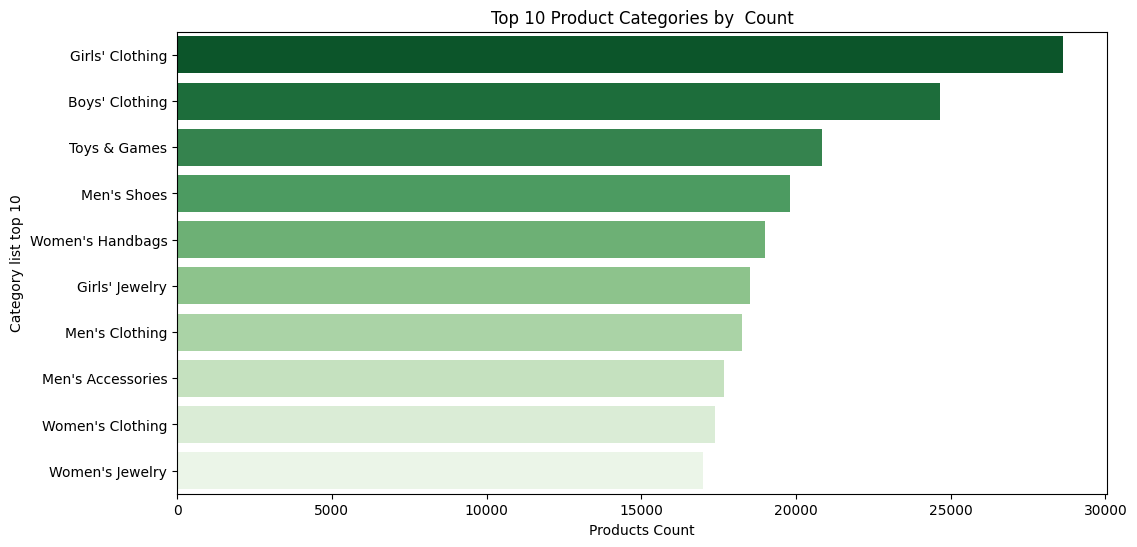

In [ ]:
#Top 10 product categories

import seaborn as sns
import matplotlib.pyplot as plt
df = merged_df
custom_palette = sns.color_palette("Greens_r", n_colors=10)

plt.figure(figsize=(12, 6))
top_categories = df['category_name'].value_counts().nlargest(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette=custom_palette)
plt.title('Top 10 Product Categories by  Count')
plt.xlabel('Products Count')
plt.ylabel('Category list top 10')
plt.show()

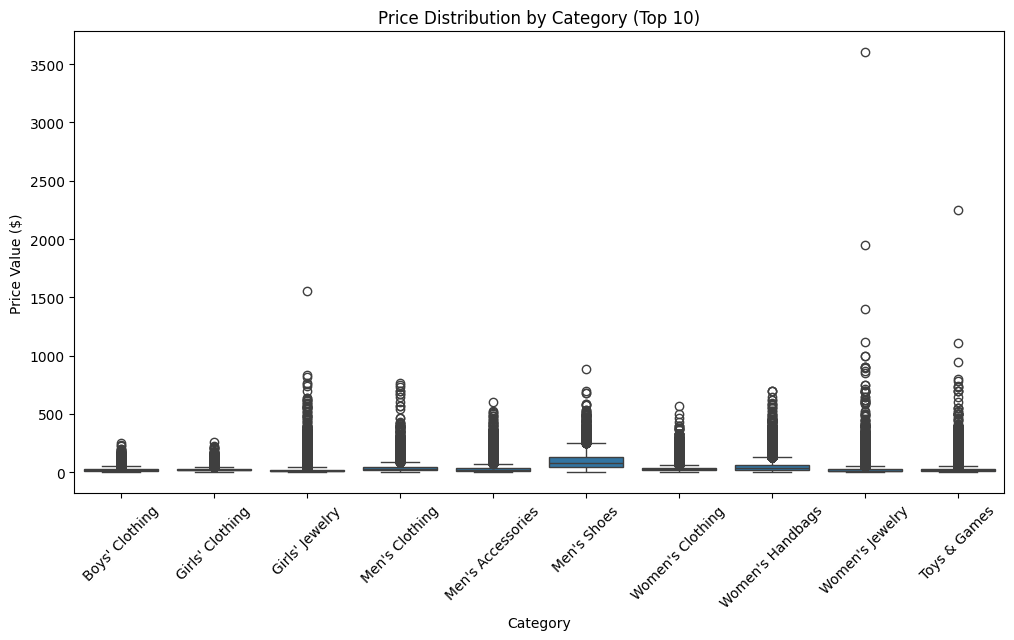

In [ ]:
# Price Distribution by Category
plt.figure(figsize=(12, 6))
top_10_categories = df['category_name'].value_counts().nlargest(10).index
sns.boxplot(x='category_name', y='price', data=df[df['category_name'].isin(top_10_categories)])
plt.title('Price Distribution by Category (Top 10)')
plt.xlabel('Category')
plt.ylabel('Price Value ($)')
plt.xticks(rotation=45)
plt.show()

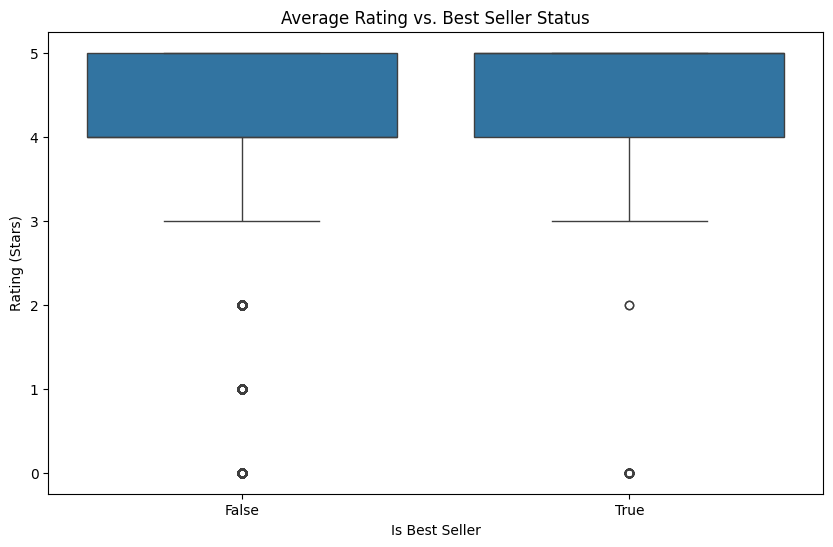

In [ ]:
custom_palette = sns.color_palette("Blues_r", n_colors=2)
plt.figure(figsize=(10, 6))
sns.boxplot(x='isBestSeller', y='stars', data=df)
plt.title('Average Rating vs. Best Seller Status')
plt.xlabel('Is Best Seller')
plt.ylabel('Rating (Stars)')
plt.show()

In [ ]:
#teemap
import plotly.express as px

# Group by category_name and sum the prices
category_prices = df.groupby('category_name')['price'].sum().reset_index()

# Sort categories by price in descending order
category_prices = category_prices.sort_values(by='price', ascending=False)

# Create a treemap plot
fig = px.treemap(category_prices,
                 path=['category_name'],
                 values='price',
                 title='Distribution of Product Prices by Category',
                 color='price',
                 color_continuous_scale='Greens')

fig.show()

# **Data preprocessing**

In [ ]:
data = merged_df

In [ ]:
# Sample data

for col in data.columns:
  for val in data[col][:1]:
    print(col,": ",val)

category_id :  1
category_name :  Beading & Jewelry Making
asin :  B08YNTXFJG
title :  Duufin 120 Pieces Acrylic Keychain Blanks Set Including 40 Pieces Rectangle Acrylic Ornament Blanks (3 x 7cm) 40 Pieces Key Rings with Chain and 40 Pieces Jump Rings for DIY Projects and Craft
imgUrl :  https://m.media-amazon.com/images/I/71czFH2QUML._AC_UL320_.jpg
productURL :  https://www.amazon.com/dp/B08YNTXFJG
stars :  5
reviews :  510
price :  9.99
listPrice :  0.0
isBestSeller :  False
boughtInLastMonth :  50


**Load the LLM model**

In [ ]:
data.columns

Index(['category_id', 'category_name', 'asin', 'title', 'imgUrl', 'productURL',
       'stars', 'reviews', 'price', 'listPrice', 'isBestSeller',
       'boughtInLastMonth'],
      dtype='object')

In [ ]:
# Prepare input_text by concatenating multiple columns
data['input_text'] = data.apply(lambda row: f"Describe this product: Product title {row['title']}, Category name {row['category_name']}, {row['category_id']} Category id, {row['reviews']} reviewers count,{row['price']} price , bought In LastMonth {row['boughtInLastMonth']}, isBestSeller {row['isBestSeller']}.", axis=1)
data['target_text'] = data['stars'].apply(lambda x: f"The estimated star is {x}")

# Split data
train_data, val_data = train_test_split(data, test_size=0.1)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], max_length=512, truncation=True, padding="max_length")
    model_inputs['labels'] = tokenizer(examples['target_text'], max_length=100, truncation=True, padding="max_length").input_ids
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1283703 [00:00<?, ? examples/s]

Map:   0%|          | 0/142634 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSeq2SeqLM

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # where to save the model
    evaluation_strategy="epoch",     # evaluation is done at the end of each epoch
    learning_rate=5e-5,              # learning rate
    per_device_train_batch_size=4,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    num_train_epochs=1,              # number of training epochs
    weight_decay=0.01                # strength of weight decay
)

# Load the model
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # your training dataset
    eval_dataset=val_dataset,        # your validation dataset
    tokenizer=tokenizer,             # your tokenizer
)

# Start training
# trainer.train()

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
# Example usage:
# Let's say you want to fill the missing values in the 'stars' column
# The following code will predict missing star ratings using the trained model.

# Initialize the transformer model
Data_imputting = pipeline("fill-mask", model="facebook/bart-base")

# Iterate over the DataFrame and use the fill_missing pipeline to impute missing values.
for index, row in data.iterrows():
  if pd.isnull(row['stars']):  # Check for missing values in the 'stars' column.
      input_text = row['input_text'] # Use the 'input_text' as the input for the model
      result = Data_imputting(input_text)  # Get predictions from the model
      predicted_star = result[0]['token_str']  # Get the predicted star value
      try:
        predicted_star = int(float(predicted_star)) #Try to convert to int
      except ValueError:
          predicted_star = np.nan  # Or handle the error as needed
          print(f"Error converting prediction to int for input: {input_text}")
          print(f"Prediction: {predicted_star}")
      data.loc[index, 'stars'] = predicted_star # Assign the prediction to the DataFrame

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# **LLM loaded dataset**

In [ ]:
# data.to_csv('Dataset/new_LLM_data.csv', index=False)
data_LLM = pd.read_csv('Dataset/new_LLM_data.csv')
data_LLM['user_id'] = data_LLM['reviews']
data_LLM = data_LLM.drop(['title','imgUrl','productURL','reviews'], axis=1)
print(data_LLM.columns)
dataset = data_LLM

# dataset = data_LLM.sample(n=80000, random_state=42)

Index(['category_id', 'category_name', 'asin', 'stars', 'price', 'listPrice',
       'isBestSeller', 'boughtInLastMonth', 'input_text', 'target_text',
       'user_id'],
      dtype='object')


In [ ]:
data_LLM.head()

,category_id,category_name,asin,stars,price,listPrice,isBestSeller,boughtInLastMonth,input_text,target_text,user_id
0,1,Beading & Jewelry Making,B08YNTXFJG,5,9.99,0.0,False,50,Describe this product: Product title Duufin 12...,The estimated star is 5,510
1,1,Beading & Jewelry Making,B08DXSF5PZ,5,8.99,0.0,False,0,Describe this product: Product title DIY Tray ...,The estimated star is 5,584
2,1,Beading & Jewelry Making,B096JGXQN5,4,12.79,0.0,False,50,Describe this product: Product title GTOTd I L...,The estimated star is 4,245
3,1,Beading & Jewelry Making,B0BZXW1ZGS,5,16.99,0.0,False,0,Describe this product: Product title Xuhal 100...,The estimated star is 5,1
4,1,Beading & Jewelry Making,B0BR8B472F,4,15.99,0.0,False,50,Describe this product: Product title Large Dic...,The estimated star is 4,10


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# User-item and item-item similarity (Collaborative Filtering Features)
user_item_matrix = dataset.pivot_table(index='user_id',
                                      columns='category_id',
                                      values='stars',
                                      aggfunc='mean').fillna(0)
user_similarity = cosine_similarity(user_item_matrix)
item_similarity = cosine_similarity(user_item_matrix.T)

# Normalize the matrices
def normalize_matrix(matrix):
    user_ratings_mean = np.mean(matrix, axis=1)
    R_demeaned = matrix - user_ratings_mean.reshape(-1, 1)
    return R_demeaned, user_ratings_mean

# Create the user-item matrices for values
# Assuming 'UserId' and 'ProductId' are the correct column names
user_item_matrix = dataset.pivot_table(index='user_id',
                                      columns='category_id',
                                      values='stars',
                                      aggfunc='mean').fillna(0)
R_value, user_ratings_mean = normalize_matrix(user_item_matrix.values)

# **Traditional SVD**

Mean Squared Error: 0.4585
Root Mean Squared Error: 0.6771


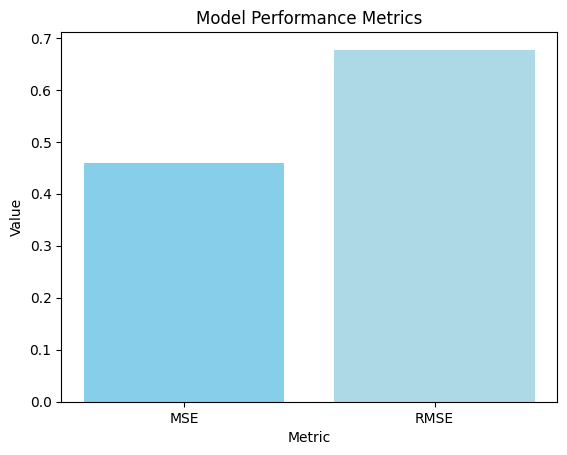

In [ ]:
# Add Traditional SVD algorithm
from scipy.sparse.linalg import svds

def Traditional_SVD(R, k):
    # Perform SVD
    U, sigma, Vt = svds(R, k=k)
    # Convert sigma to diagonal matrix
    sigma = np.diag(sigma)
    return U, sigma, Vt

# Perform SVD on the user-item matrix
U_value, sigma_value, Vt_value = Traditional_SVD(R_value, k=100)

# Reconstruct the matrices
def reconstruct_matrix(U, sigma, Vt, user_ratings_mean):
    return np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

R_pred_value = reconstruct_matrix(U_value, sigma_value, Vt_value, user_ratings_mean)
predicted_ratings_value = pd.DataFrame(R_pred_value, columns=user_item_matrix.columns)

# Calculate MAE and RMSE
def calculate_metrics(true_values, predicted_values):

    MSE = mean_squared_error(true_values, predicted_values, squared=False)
    RMSE = np.sqrt(mse)
    return MSE, RMSE

# Assuming you have the true ratings and predicted ratings
true_ratings = user_item_matrix.values.flatten()
valid_indices = true_ratings > 0
predicted_ratings = R_pred_value.flatten()

mse, rmse = calculate_metrics(true_ratings[valid_indices], predicted_ratings[valid_indices])
# Create a NumPy array to store the metrics
metrics = np.array([mse, rmse])

# Save metrics to an .npy file
# np.save('results/metrics.npy', metrics)

# Load metrics from the .npy file
metrics = np.load('results/metrics.npy')
mse, rmse = metrics[0], metrics[1]



print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Create a list of metrics and their corresponding values
metrics_data = [mse, rmse]
metrics_labels = ['MSE', 'RMSE']

# Create a bar plot with different colors for each bar
plt.bar(metrics_labels, metrics_data, color=['skyblue', 'lightblue'])  # Customize colors here

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Metrics')

# Show the plot
plt.show()


In [ ]:
# Generate recommendations for each user
def recommend_products(predicted_ratings_df, user_item_matrix, top_n=5):
    recommendations = {}
    for user_id in user_item_matrix.index:
        user_row = predicted_ratings_df.loc[user_id]
        # Get the indices of the top N products
        recommended_indices = user_row.nlargest(top_n).index
        recommendations[user_id] = recommended_indices.tolist()
    return recommendations

# Create a DataFrame for predicted ratings for easier access
predicted_ratings_df = pd.DataFrame(R_pred_value, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Get recommendations
recommended_products = recommend_products(predicted_ratings_df, user_item_matrix, top_n=5)

# Display recommendations
for user, products in recommended_products.items():
    print(f"User {user} is recommended products: {products}")


Streaming output truncated to the last 5000 lines.
User 7463 is recommended products: [165, 1, 35, 108, 216]
User 7465 is recommended products: [179, 71, 128, 72, 2]
User 7466 is recommended products: [51, 270, 166, 49, 260]
User 7467 is recommended products: [16, 48, 51, 172, 143]
User 7468 is recommended products: [270, 69, 114, 112, 51]
User 7469 is recommended products: [3, 211, 141, 143, 132]
User 7472 is recommended products: [69, 255, 49, 4, 240]
User 7473 is recommended products: [230, 128, 157, 172, 219]
User 7474 is recommended products: [84, 72, 172, 3, 255]
User 7476 is recommended products: [48, 260, 216, 68, 121]
User 7477 is recommended products: [124, 228, 3, 114, 110]
User 7478 is recommended products: [230, 48, 128, 172, 260]
User 7479 is recommended products: [240, 17, 48, 206, 166]
User 7481 is recommended products: [211, 132, 128, 141, 157]
User 7482 is recommended products: [270, 69, 114, 112, 51]
User 7483 is recommended products: [175, 51, 165, 216, 32]
User 748

In [ ]:
user_id = 234

if user_id in recommended_products:
    recommended_items = recommended_products[user_id]
    print(f"User {user_id} is recommended products: {recommended_items}")
else:
    print(f"No recommendations found for user {user_id}")

User 234 is recommended products: [252, 35, 49, 172, 84]
